In [71]:
import cv2
import glob 
import dlib
import random
import numpy as np
import math
from imutils import face_utils
from matplotlib import pyplot as plt

In [72]:
import cv2
import scipy
from scipy import stats
import numpy as np
from collections import defaultdict


def update_c(C,hist):
    while True:
        groups=defaultdict(list)

        for i in range(len(hist)):
            if(hist[i] == 0):
                continue
            d=np.abs(C-i)
            index=np.argmin(d)
            groups[index].append(i)

        new_C=np.array(C)
        for i,indice in groups.items():
            if(np.sum(hist[indice])==0):
                continue
            new_C[i]=int(np.sum(indice*hist[indice])/np.sum(hist[indice]))

        if(np.sum(new_C-C)==0):
            break
        C=new_C

    return C,groups

def K_histogram(hist):

    alpha=0.001
    N=80
    C=np.array([128])

    while True:
        C,groups=update_c(C,hist)

        new_C=set()
        for i,indice in groups.items():
            if(len(indice)<N):
                new_C.add(C[i])
                continue

            z, pval=stats.normaltest(hist[indice])
            if(pval<alpha):
                left=0 if i==0 else C[i-1]
                right=len(hist)-1 if i ==len(C)-1 else C[i+1]
                delta=right-left
                if(delta >=3):
                    c1=(C[i]+left)/2
                    c2=(C[i]+right)/2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    new_C.add(C[i])
            else:
                new_C.add(C[i])
        if(len(new_C)==len(C)):
            break
        else:
            C=np.array(sorted(new_C))
    return C


def caart(img):

    kernel=np.ones((2,2), np.uint8)
    output=np.array(img)
    x,y,c=output.shape
    for i in range(c):
        output[:,:,i]=cv2.bilateralFilter(output[:,:,i],5,150,150)

    edge=cv2.Canny(output, 100, 200)
    output=cv2.cvtColor(output,cv2.COLOR_RGB2HSV)

    hists = []

    hist,_=np.histogram(output[:,:,0],bins =np.arange(180+1))
    hists.append(hist)
    hist,_=np.histogram(output[:,:,1],bins =np.arange(256+1))
    hists.append(hist)
    hist,_=np.histogram(output[:,:,2],bins =np.arange(256+1))
    hists.append(hist)


    C=[]
    for h in hists:
        C.append(K_histogram(h))

    output=output.reshape((-1,c))
    for i in range(c):
        channel=output[:,i]
        index=np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:,i]=C[i][index]
    output=output.reshape((x,y,c))
    output=cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

    contours,_=cv2.findContours(edge,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(output,contours,-1,0,thickness=1)
    for i in range(3):
        output[:,:,i]=cv2.erode(output[:,:,i], kernel, iterations=1)
    return output

In [84]:
input_image_path = "Images/karan_crop.jpg"
img = cv2.imread(input_image_path)

cartoon = caart(img)

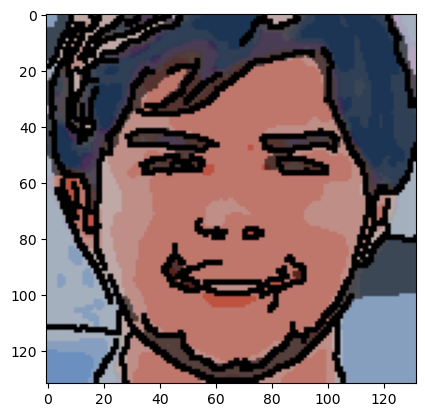

In [85]:
plt.imshow(cv2.cvtColor(cartoon, cv2.COLOR_BGR2RGB))